# 对Neal's funnel的测试

In [1]:
using Random
using Distributions
using KernelDensity
using DataFrames
using XLSX
include("../Inversion/AffineInvariantMCMC.jl")
include("../Inversion/GMNVI.jl")
include("../Inversion/GMWVI.jl")
include("../Inversion/Plot.jl")
include("../Inversion/DF_GMVI.jl")
include("../Inversion/GMBBVI.jl")
include("../Inversion/NUTS.jl")
include("../Inversion/WALNUTS.jl")
include("./MultiModal_modified.jl")
include("../Inversion/initialize_with_annealing.jl")
Random.seed!(111);

**Geometry of Neal's funnel** 

Consider the $(d + 1)$-dimensional funnel distribution, defined over $\theta = (\omega,\mathbf{x})$ with $\omega \in \mathbb{R}$ and $\mathbf{x} = (x_1, \dots, x_d) \in \mathbb{R}^d$, where  

$$
\omega \sim \mathcal{N}(0, 9), \quad x_i | \omega \sim \mathcal{N}\left(0, e^{\omega}\right), \quad i = 1, \dots, d. 
$$


In [2]:
function Gaussian_mixture_NGFVI(func_V, w0, μ0, Σ0; diagonal_covariance::Bool = false,  Hessian_correct_GM::Bool = false, N_ens = -1, N_ens_GM = -1, N_iter = 100, dt = 1.0e-3)

    N_modes, N_θ = size(μ0)
    
    if N_ens == -1  N_ens = 2*N_θ+1   end

    T =  N_iter * dt
    x0_w = w0
    x0_mean = μ0
    xx0_cov = Σ0
    sqrt_matrix_type = "Cholesky"
    
    objs = []

    gmnviobj = GMNVI_Run(
    func_V, 
    T,
    N_iter,
    # Initial condition
    x0_w, x0_mean, xx0_cov;
    sqrt_matrix_type = sqrt_matrix_type,
    diagonal_covariance = diagonal_covariance,
    # setup for Gaussian mixture part
    quadrature_type_GM = "mean_point",
    # setup for potential function part
    quadrature_type = "mean_point",
    Hessian_correct_GM = Hessian_correct_GM,
    N_ens = N_ens)
    
    push!(objs, gmnviobj)


    return objs
end



# 新增辅助函数：计算高斯混合模型的期望和协方差
function calculate_gm_stats(weights, means, covs)
    # 确保权重归一化
    w = weights / sum(weights)
    N_modes, N_θ = size(means)

    # 计算总期望 (mean)
    total_mean = zeros(N_θ)
    for i in 1:N_modes
        total_mean += w[i] * means[i, :]
    end

    # 计算总协方差 (variance)
    # Cov[X] = E[Cov[X|Z]] + Cov[E[X|Z]]
    # E[Cov[X|Z]] = Σ(w_i * Σ_i)
    # Cov[E[X|Z]] = Σ(w_i * μ_i * μ_i') - E[X]E[X]'
    e_cov = zeros(N_θ, N_θ)
    cov_e = zeros(N_θ, N_θ)
    for i in 1:N_modes
        e_cov += w[i] * covs[i, :, :]
        cov_e += w[i] * (means[i, :] * means[i, :]')
    end
    total_cov = e_cov + cov_e - (total_mean * total_mean')
    
    return total_mean, total_cov
end

# 新增辅助函数：计算样本的期望和协方差
function calculate_sample_stats(samples)
    # samples: N_θ x N_samples
    if isempty(samples) || size(samples, 2) < 2
        return fill(NaN, size(samples, 1)), fill(NaN, size(samples, 1), size(samples, 1))
    end
    # 使用 Statistics.mean 和 Statistics.cov
    total_mean = mean(samples, dims=2)[:, 1]
    total_cov = cov(samples') # cov 需要变量在列上，所以转置
    return total_mean, total_cov
end



function Gaussian_mixture_NGFVI(func_V, w0, μ0, Σ0; diagonal_covariance::Bool = false,  Hessian_correct_GM::Bool = false, N_ens = -1, N_ens_GM = -1, N_iter = 100, dt = 1.0e-3)

    N_modes, N_θ = size(μ0)
    
    if N_ens == -1  N_ens = 2*N_θ+1   end

    T =  N_iter * dt
    x0_w = w0
    x0_mean = μ0
    xx0_cov = Σ0
    sqrt_matrix_type = "Cholesky"
    
    objs = []

    gmnviobj = GMNVI_Run(
    func_V, 
    T,
    N_iter,
    # Initial condition
    x0_w, x0_mean, xx0_cov;
    sqrt_matrix_type = sqrt_matrix_type,
    diagonal_covariance = diagonal_covariance,
    # setup for Gaussian mixture part
    quadrature_type_GM = "mean_point",
    # setup for potential function part
    quadrature_type = "mean_point",
    Hessian_correct_GM = Hessian_correct_GM,
    N_ens = N_ens)
    
    push!(objs, gmnviobj)


    return objs
end



# 新增辅助函数：计算高斯混合模型的期望和协方差
function calculate_gm_stats(weights, means, covs)
    # 确保权重归一化
    w = weights / sum(weights)
    N_modes, N_θ = size(means)

    # 计算总期望 (mean)
    total_mean = zeros(N_θ)
    for i in 1:N_modes
        total_mean += w[i] * means[i, :]
    end

    # 计算总协方差 (variance)
    # Cov[X] = E[Cov[X|Z]] + Cov[E[X|Z]]
    # E[Cov[X|Z]] = Σ(w_i * Σ_i)
    # Cov[E[X|Z]] = Σ(w_i * μ_i * μ_i') - E[X]E[X]'
    e_cov = zeros(N_θ, N_θ)
    cov_e = zeros(N_θ, N_θ)
    for i in 1:N_modes
        e_cov += w[i] * covs[i, :, :]
        cov_e += w[i] * (means[i, :] * means[i, :]')
    end
    total_cov = e_cov + cov_e - (total_mean * total_mean')
    
    return total_mean, total_cov
end

# 新增辅助函数：计算样本的期望和协方差
function calculate_sample_stats(samples)
    # samples: N_θ x N_samples
    if isempty(samples) || size(samples, 2) < 2
        return fill(NaN, size(samples, 1)), fill(NaN, size(samples, 1), size(samples, 1))
    end
    # 使用 Statistics.mean 和 Statistics.cov
    total_mean = mean(samples, dims=2)[:, 1]
    total_cov = cov(samples') # cov 需要变量在列上，所以转置
    return total_mean, total_cov
end



function visualization_comparison_2d(ax, obj_GMNVI, obj_GMNVI_D, obj_GMWVI, obj_GMBBVI, ens_MCMC, ens_NUTS, ens_WALNUTS; Nx = 200, Ny = 200, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0],
        func_F = nothing, func_Phi = nothing, bandwidth=nothing, make_label::Bool=false, N_iter=500)

        x_min, x_max = x_lim
        y_min, y_max = y_lim

        xx = LinRange(x_min, x_max, Nx)
        yy = LinRange(y_min, y_max, Ny)
        dx, dy = xx[2] - xx[1], yy[2] - yy[1]
        X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'

        Z_ref = (func_Phi === nothing ? posterior_2d(func_F, X, Y, "func_F") : posterior_2d(func_Phi, X, Y, "func_Phi"))
        color_lim = (minimum(Z_ref), maximum(Z_ref))
        ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

        error = zeros(7, N_iter+1)
        variances_omega = zeros(7, N_iter+1)
        variances_x = zeros(7, N_iter+1)

        # NGF-VI
        if obj_GMNVI!=nothing
                for iter = 0:N_iter
                x_w = exp.(obj_GMNVI.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj_GMNVI.x_mean[iter+1][:,1:2]
                xx_cov = obj_GMNVI.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[1, iter+1] = norm(Z - Z_ref,1)*dx*dy
                _, gm_cov = calculate_gm_stats(x_w, x_mean, xx_cov)
                variances_omega[1, iter+1] = gm_cov[1,1]
                variances_x[1, iter+1] = gm_cov[2,2]
                
                if iter == N_iter
                        ax[2].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[2].scatter([obj_GMNVI.x_mean[1][:,1];], [obj_GMNVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                        ax[2].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                        mean_val, cov_val = calculate_gm_stats(x_w, x_mean, xx_cov)
                        text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                        ax[2].text(0.05, 0.95, text_str, transform=ax[2].transAxes, fontsize=8,
                                   verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
                end
                end
        end

        # NGF-VI-D
        if obj_GMNVI_D!=nothing
                for iter = 0:N_iter
                x_w = exp.(obj_GMNVI_D.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj_GMNVI_D.x_mean[iter+1][:,1:2]
                xx_cov = obj_GMNVI_D.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[2, iter+1] = norm(Z - Z_ref,1)*dx*dy
                _, gm_cov = calculate_gm_stats(x_w, x_mean, xx_cov)
                variances_omega[2, iter+1] = gm_cov[1,1]
                variances_x[2, iter+1] = gm_cov[2,2]
                
                if iter == N_iter
                        ax[3].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[3].scatter([obj_GMNVI_D.x_mean[1][:,1];], [obj_GMNVI_D.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                        ax[3].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                        mean_val, cov_val = calculate_gm_stats(x_w, x_mean, xx_cov)
                        text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                        ax[3].text(0.05, 0.95, text_str, transform=ax[3].transAxes, fontsize=8,
                                   verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
                end
                end
        end

        # GMWVI
        if obj_GMWVI!=nothing
                for iter = 0:N_iter
                x_w = exp.(obj_GMWVI.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj_GMWVI.x_mean[iter+1][:,1:2]
                xx_cov = obj_GMWVI.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[3, iter+1] = norm(Z - Z_ref,1)*dx*dy
                _, gm_cov = calculate_gm_stats(x_w, x_mean, xx_cov)
                variances_omega[3, iter+1] = gm_cov[1,1]
                variances_x[3, iter+1] = gm_cov[2,2]
                
                if iter == N_iter
                        ax[4].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[4].scatter([obj_GMWVI.x_mean[1][:,1];], [obj_GMWVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                        ax[4].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                        mean_val, cov_val = calculate_gm_stats(x_w, x_mean, xx_cov)
                        text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                        ax[4].text(0.05, 0.95, text_str, transform=ax[4].transAxes, fontsize=8,
                                   verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
                end
                end
        end

        # GMBBVI
        if obj_GMBBVI !=nothing
                for iter = 0:N_iter
                x_w = exp.(obj_GMBBVI.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj_GMBBVI.x_mean[iter+1][:,1:2]
                xx_cov = obj_GMBBVI.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[4, iter+1] = norm(Z - Z_ref,1)*dx*dy
                _, gm_cov = calculate_gm_stats(x_w, x_mean, xx_cov)
                variances_omega[4, iter+1] = gm_cov[1,1]
                variances_x[4, iter+1] = gm_cov[2,2]
                
                if iter == N_iter
                        ax[5].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[5].scatter([obj_GMBBVI.x_mean[1][:,1];], [obj_GMBBVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                        ax[5].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                        mean_val, cov_val = calculate_gm_stats(x_w, x_mean, xx_cov)
                        text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                        ax[5].text(0.05, 0.95, text_str, transform=ax[5].transAxes, fontsize=8,
                                   verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
                end
                end
        end

        # MCMC
        if ens_MCMC!=nothing
                boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))
                for iter = 0:N_iter
                if bandwidth==nothing
                        kde_iter=kde(ens_MCMC[:,:,iter+1]';boundary=boundary,npoints=(Nx,Ny))
                else
                        kde_iter=kde(ens_MCMC[:,:,iter+1]';boundary=boundary,npoints=(Nx,Ny),bandwidth=bandwidth)
                end

                Z = kde_iter.density
                sum_Z = sum(Z)
                if sum_Z > 0 Z ./= (sum_Z*dx*dy) end
                error[5, iter+1] = norm(Z - Z_ref,1)*dx*dy
                if size(samples_iter, 2) > 1
                    _, sample_cov = calculate_sample_stats(samples_iter[1:2, :])
                    variances_omega[5, iter+1] = sample_cov[1,1]
                    variances_x[5, iter+1] = sample_cov[2,2]
                else
                    variances_omega[5, iter+1] = NaN
                    variances_x[5, iter+1] = NaN
                end
            
                if iter == N_iter
                        last_n_iters=10
                        last_ens=hcat([ens_MCMC[:,:,i] for i in N_iter+2-last_n_iters:N_iter+1]...)
                        last_ens_number=size(last_ens,2)

                        if bandwidth==nothing
                        kde_last=kde(last_ens'; boundary=boundary, npoints=(Nx,Ny))
                        else
                        kde_last=kde(last_ens'; boundary=boundary, npoints=(Nx,Ny), bandwidth=bandwidth)
                        end

                        Z = kde_last.density
                        sum_Z = sum(Z)
                        if sum_Z > 0 Z ./= (sum_Z*dx*dy) end

                        ax[6].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[6].scatter(last_ens[1,:], last_ens[2,:], marker=".", color="red", s=10, alpha=100/last_ens_number)
                        ax[6].set_xlim(x_lim)
                        ax[6].set_ylim(y_lim)
                        
                        mean_val, cov_val = calculate_sample_stats(last_ens[1:2, :])
                        if !any(isnan, mean_val)
                            text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                            ax[6].text(0.05, 0.95, text_str, transform=ax[6].transAxes, fontsize=8,
                                       verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
                        end
                        end
                end
        end

        # NUTS Error Calculation
        if ens_NUTS!=nothing
                boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))
                samples_per_iter = 100
                total_samples = size(ens_NUTS, 2)
                for iter = 0:N_iter
                        n_samples_end = min((iter + 1) * samples_per_iter, total_samples)
                        if n_samples_end < 2
                                error[6, iter+1] = NaN
                                continue
                        end
                        samples_iter = ens_NUTS[:, 1:n_samples_end]
                        
                        if bandwidth==nothing
                                kde_iter=kde(samples_iter';boundary=boundary,npoints=(Nx,Ny))
                        else
                                kde_iter=kde(samples_iter';boundary=boundary,npoints=(Nx,Ny),bandwidth=bandwidth)
                        end
        
                        Z = kde_iter.density
                        sum_Z = sum(Z)
                        if sum_Z > 0 Z ./= (sum_Z*dx*dy) end
                        error[6, iter+1] = norm(Z - Z_ref,1)*dx*dy
                        if size(samples_iter, 2) > 1
                            _, sample_cov = calculate_sample_stats(samples_iter[1:2, :])
                            variances_omega[6, iter+1] = sample_cov[1,1]
                            variances_x[6, iter+1] = sample_cov[2,2]
                        else
                            variances_omega[6, iter+1] = NaN
                            variances_x[6, iter+1] = NaN
                        end
                end
        end
        
        # WALNUTS Error Calculation
        if ens_WALNUTS!=nothing
                boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))
                samples_per_iter = 100
                total_samples = size(ens_WALNUTS, 2)
                for iter = 0:N_iter
                        n_samples_end = min((iter + 1) * samples_per_iter, total_samples)
                        if n_samples_end < 2
                                error[7, iter+1] = NaN
                                continue
                        end
                        samples_iter = ens_WALNUTS[:, 1:n_samples_end]

                        if bandwidth==nothing
                                kde_iter=kde(samples_iter';boundary=boundary,npoints=(Nx,Ny))
                        else
                                kde_iter=kde(samples_iter';boundary=boundary,npoints=(Nx,Ny),bandwidth=bandwidth)
                        end
        
                        Z = kde_iter.density
                        sum_Z = sum(Z)
                        if sum_Z > 0 Z ./= (sum_Z*dx*dy) end
                        error[7, iter+1] = norm(Z - Z_ref,1)*dx*dy
                        if size(samples_iter, 2) > 1
                            _, sample_cov = calculate_sample_stats(samples_iter[1:2, :])
                            variances_omega[7, iter+1] = sample_cov[1,1]
                            variances_x[7, iter+1] = sample_cov[2,2]
                        else
                            variances_omega[7, iter+1] = NaN
                            variances_x[7, iter+1] = NaN
                        end
                end
        end
    
        # Helper for plotting final MCMC-type distributions
        function plot_mcmc_on_ax(ax_plt, samples, title)
            if samples === nothing || size(samples, 2) < 20
                ax_plt.text(0.5, 0.5, "No Samples", ha="center", va="center")
                ax_plt.set_title(title)
                ax_plt.set_xlim(x_lim)
                ax_plt.set_ylim(y_lim)
                return
            end
        
            ax_plt.set_title(title)
        
            burn_in = div(size(samples, 2), 2)
            samples_to_plot = samples[:, burn_in+1:end]
        
            if size(samples_to_plot, 2) < 2
                ax_plt.text(0.5, 0.5, "No Samples Post Burn-in", ha="center", va="center")
                return
            end

            kde_boundary = ((x_lim[1], x_lim[2]), (y_lim[1], y_lim[2]))
        
            kde_res = kde(samples_to_plot', boundary=kde_boundary, npoints=(Nx, Ny), bandwidth=bandwidth)
            Z_kde = kde_res.density
            if sum(Z_kde) > 0 Z_kde ./= sum(Z_kde) * dx * dy end
            ax_plt.pcolormesh(X, Y, Z_kde, cmap="viridis", vmin=color_lim[1], vmax=color_lim[2])
        
            alpha_val = min(1.0, 100 / size(samples_to_plot, 2))
            ax_plt.scatter(samples_to_plot[1, :], samples_to_plot[2, :], 
                           marker=".", color="red", s=10, alpha=alpha_val)

            samples_2d = samples_to_plot[1:2, :]
            mean_val, cov_val = calculate_sample_stats(samples_2d)
            
            if !any(isnan, mean_val) && !any(isnan, cov_val)
                text_str = "μ: [$(round(mean_val[1], digits=2)), $(round(mean_val[2], digits=2))]\\nσ²: [$(round(cov_val[1,1], digits=2)), $(round(cov_val[2,2], digits=2))]"
                ax_plt.text(0.05, 0.95, text_str, transform=ax_plt.transAxes, fontsize=8,
                           verticalalignment="top", bbox=Dict("boxstyle"=>"round,pad=0.3", "facecolor"=>"white", "alpha"=>0.7))
            end
        
            ax_plt.set_xlim(x_lim)
            ax_plt.set_ylim(y_lim)
        end

    # Plot final distributions for NUTS and WALNUTS to ax[7] and ax[8]
    plot_mcmc_on_ax(ax[7], ens_NUTS, "NUTS")
    plot_mcmc_on_ax(ax[8], ens_WALNUTS, "WALNUTS")

    # Error plot on ax[9]
    ax[9].semilogy(Array(0:N_iter), error', label=["NGF-VI","NGF-VI-D","WGF-VI","GMBBVI","MCMC","NUTS","WALNUTS"])   
    l1_error = error 

    # L1 Error plot on ax[9]
    ax[9].set_title("L1 Error vs Iteration")
    ax[9].set_xlabel("Iteration")
    ax[9].set_ylabel("L1 Error")
    ax[9].grid(true, which="both", linestyle="--", linewidth=0.5)

    # 绘制 Var(ω) 收敛图
    ax[10].semilogy(Array(0:N_iter), variances_omega')
    ax[10].set_title("Var(ω) Convergence")
    ax[10].set_xlabel("Iteration")
    ax[10].set_ylabel("Variance")
    ax[10].grid(true, which="both", linestyle="--", linewidth=0.5)
    
    # 绘制 Var(x) 收敛图
    ax[11].semilogy(Array(0:N_iter), variances_x')
    ax[11].set_title("Var(x) Convergence")
    ax[11].set_xlabel("Iteration")
    ax[11].set_ylabel("Variance")
    ax[11].grid(true, which="both", linestyle="--", linewidth=0.5)

    ymin, ymax = ax[9].get_ylim()
    if ymin > 0.1
            ax[9].set_ylim(0.1, ymax)
    end
end

visualization_comparison_2d (generic function with 1 method)

正在运行变分推断方法...
NGF-VI finished in 0.0s
NGF-VI-D finished in 0.0s
WGF-VI finished in 0.0s


[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)
[ Info: ("iter = ", 150, " / ", 500)
[ Info: ("iter = ", 200, " / ", 500)
[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)
[ Info: ("iter = ", 400, " / ", 500)
[ Info: ("iter = ", 450, " / ", 500)


GMBBVI finished in 5.99s
正在运行MCMC方法...
MCMC finished in 0.0s
正在运行基于HMC的方法...
NUTS finished in 0.0s
WALNUTS finished in 0.0s
正在可视化结果...


[ Info: ("iter = ", 500, " / ", 500)


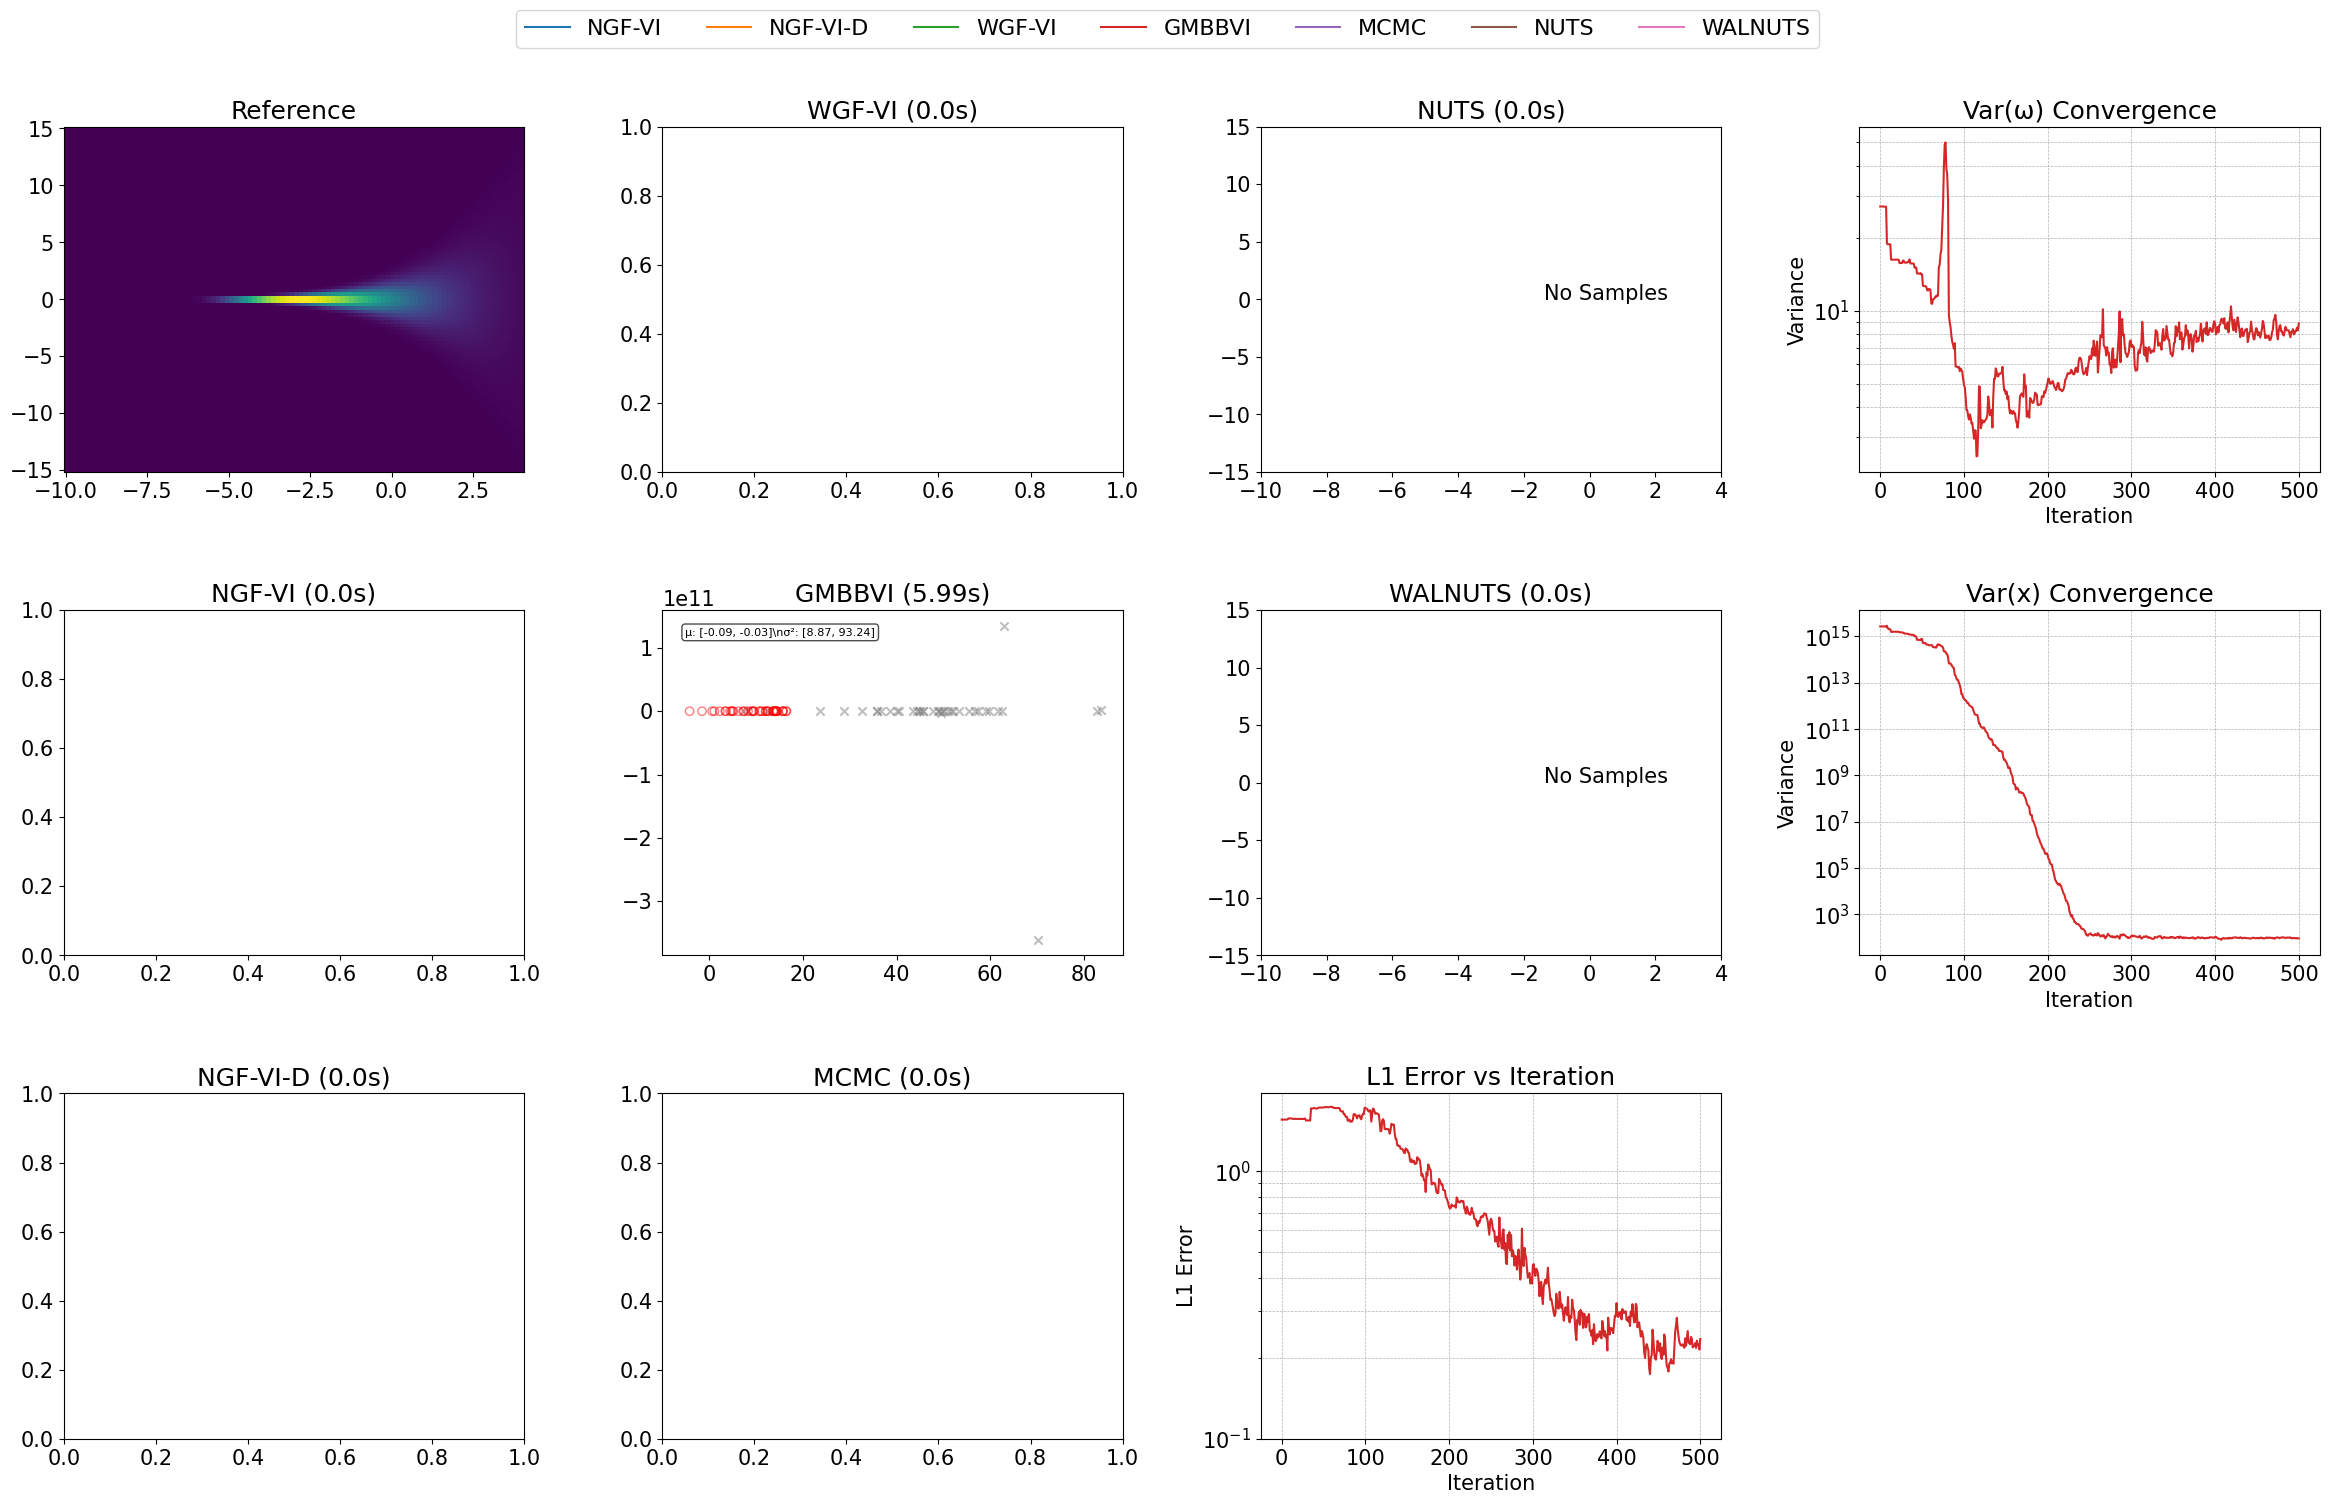

In [ ]:
# 实验参数
N_modes = 40       # 高斯混合模型中的模态数量
N_ens= 500        # MCMC中的粒子数
N_bbvi_sample = 5  # GMBBVI中用于蒙特卡洛积分的样本数
N_iter = 500       # 迭代次数
Nx, Ny = 100, 100  # 网格分辨率

# 为单个测试案例设置绘图
fig, ax = PyPlot.subplots(nrows=3, ncols=4, sharex=false, sharey=false, figsize=(24, 16))
ax = ax[:] # Flatten the axis array for easier indexing (ax[1], ax[2], ...)

# --- 定义二维尼尔漏斗分布 --- 
# 参数向量为 θ = [ω, x]

# 势能函数 Φ(θ) = -log p(θ)
func_Phi(θ) = θ[1]^2/18.0 + 0.5*θ[1] + 0.5*θ[2]^2*exp(-θ[1])

# 势能的梯度 ∇Φ(θ)
func_dPhi(θ) = [θ[1]/9.0 + 0.5 - 0.5*θ[2]^2*exp(-θ[1]), θ[2]*exp(-θ[1])]

# 势能的Hessian矩阵 ∇²Φ(θ)
function func_Hessian_Phi(θ)
    ω, x = θ[1], θ[2]
    exp_m_ω = exp(-ω)
    
    H11 = 1/9.0 + 0.5 * x^2 * exp_m_ω
    H12 = -x * exp_m_ω
    H22 = exp_m_ω
    
    return [H11 H12; H12 H22]
end

# 创建一个包装函数，以满足 GMWVI 的接口要求
# 它返回 (标量, 向量, 矩阵)
function func_for_GMWVI(θ)
    return func_Phi(θ), func_dPhi(θ), func_Hessian_Phi(θ)
end

# 对数概率函数（用于某些MCMC方法）
func_logrho(θ) = -func_Phi(θ)
func_prob(θ) = exp(func_logrho(θ))

# HMC方法需要势能U的梯度，这里 U = Φ
∇U_func_hmc(θ) = func_dPhi(θ)

# --- 初始条件 ---
Random.seed!(111)
N_x = 2 # 维度是 2: (ω, x)
μ0 = [0.0, 0.0]
Σ0 = [9.0 0.0; 0.0 1.0] # 初始协方差反映了ω的先验和x的单位方差

# 变分推断方法的初始条件
x0_w  = ones(N_modes)/N_modes
x0_mean = zeros(N_modes, N_x)
xx0_cov = zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(μ0, Σ0))
    xx0_cov[im, :, :] .= Σ0
end

# MCMC方法的初始粒子系综
ens_0 = zeros(N_x, N_ens)
for j = 1:N_ens
    ens_0[:, j] = rand(MvNormal(μ0, Σ0))
end

# --- 超参数 ---
dt1 = 0.5     # NGF-VI
dt2 = 1e-4    # WGF-VI 
dt3 = 0.5     # NGF-VI-D
dt4 = 0.5     # GMBBVI
Hessian_correct_GM = false 
x0_w, x0_mean, xx0_cov = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 0.5, N_ens=N_bbvi_sample, factor = 1.0)

# --- 运行模拟 ---
time_ngf = @elapsed obj_NGFlow = nothing
# Gaussian_mixture_NGFVI(func_for_GMWVI, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1, Hessian_correct_GM=Hessian_correct_GM)[1]
println("NGF-VI finished in $(round(time_ngf, digits=2))s")
time_ngf_d = @elapsed obj_NGFlow_D = nothing
# Gaussian_mixture_NGFVI(func_for_GMWVI, x0_w, x0_mean, xx0_cov; diagonal_covariance = true, N_iter = N_iter, dt = dt3, Hessian_correct_GM=Hessian_correct_GM)[1]
println("NGF-VI-D finished in $(round(time_ngf_d, digits=2))s")
time_gmwvi = @elapsed obj_GMWVI = nothing
# Gaussian_mixture_WGFVI(func_for_GMWVI, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt2, Hessian_correct_GM=Hessian_correct_GM)[1]
println("WGF-VI finished in $(round(time_gmwvi, digits=2))s")
time_gmbbvi = @elapsed obj_GMBBVI = Gaussian_mixture_GMBBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)
println("GMBBVI finished in $(round(time_gmbbvi, digits=2))s")

time_mcmc = @elapsed ens_MCMC = nothing
# Run_StretchMove(ens_0, func_prob; output="History", N_iter=N_iter)
println("MCMC finished in $(round(time_mcmc, digits=2))s")

time_nuts = @elapsed ens_NUTS = nothing
# Run_NUTS_with_warmup(func_Phi, ∇U_func_hmc, μ0; N_iter=N_ens*50, N_warmup=div(N_ens, 1), δ_target=0.65)
println("NUTS finished in $(round(time_nuts, digits=2))s")
time_walnuts = @elapsed ens_WALNUTS = nothing
# Run_WALNUTS(μ0, func_Phi, ∇U_func_hmc; N_iter=N_ens*50, h=0.36, δ=0.21)
println("WALNUTS finished in $(round(time_walnuts, digits=2))s")

# println("\n" * "Writing GMBBVI final parameters to Excel file...")

# # 检查 GMBBVI 对象是否存在
# if @isdefined(obj_GMBBVI) && obj_GMBBVI !== nothing
#     # --- 1. 数据准备 (与之前相同) ---
#     final_log_weights = obj_GMBBVI.logx_w[end]
#     final_means = obj_GMBBVI.x_mean[end]
#     final_covs = obj_GMBBVI.xx_cov[end]
#     final_weights = exp.(final_log_weights)
#     final_weights ./= sum(final_weights)
#     N_modes_final = length(final_weights)


#     # 1. 计算 GMM 在 x 维度上的总均值 (total_mean_x)
#     #    它是所有模态均值 (final_means[:, 2]) 的加权平均
#     total_mean_x = dot(final_weights, final_means[:, 2])

#     # 2. 计算 GMM 在 x 维度上的总方差 (total_var_x)
#     #    总方差 = 内部方差的期望 + 均值之间的方差
#     #    E[Var(x|k)] = Σ w_k * C_k(x,x)
#     internal_var_exp = dot(final_weights, [final_covs[i, 2, 2] for i in 1:N_modes_final])
#     #    Var(E[x|k]) = Σ w_k * (μ_k(x) - μ_total(x))²
#     between_means_var = dot(final_weights, (final_means[:, 2] .- total_mean_x).^2)
#     #    总方差
#     total_var_x = internal_var_exp + between_means_var

    
#     # --- 2. 创建 DataFrames (与之前相同) ---

#     # 计算每个模式的贡献
#     contributions_internal = final_weights .* [final_covs[i, 2, 2] for i in 1:N_modes_final]
#     contributions_between = final_weights .* (final_means[:, 2] .- total_mean_x).^2
#     contributions_total = contributions_internal .+ contributions_between

#     # 计算贡献的百分比
#     percent_contributions = (contributions_total / total_var_x) * 100

#     df_components = DataFrame(
#         Mode = 1:N_modes_final,
#         Weight = final_weights,
#         Mean_ω = final_means[:, 1],
#         Mean_x = final_means[:, 2],
#         Cov_xx = [final_covs[i, 2, 2] for i in 1:N_modes_final],
#         Contribution_Internal = contributions_internal,
#         Contribution_Between = contributions_between,
#         Contribution_Total = contributions_total,
#         Contribution_Percent = percent_contributions
#         )
#     total_mean_gmbvvi, total_cov_gmbvvi = calculate_gm_stats(final_weights, final_means, final_covs)
#     df_stats = DataFrame(
#         Description = ["Total Mean", "Total Covariance (Row 1)", "Total Covariance (Row 2)"],
#         Value_ω = [total_mean_gmbvvi[1], total_cov_gmbvvi[1, 1], total_cov_gmbvvi[2, 1]],
#         Value_x = [total_mean_gmbvvi[2], total_cov_gmbvvi[1, 2], total_cov_gmbvvi[2, 2]]
#     )
    
#     # --- 3. 写入 Excel 文件  ---
#     excel_filename = "gmbvvi_N_modes_$(N_modes).xlsx"
    
#     # 使用 "w" (write) 模式。这将覆盖任何现有文件。
#     XLSX.openxlsx(excel_filename, mode="w") do xf
#         # 添加第一个工作表并写入数据
#         sheet1 = XLSX.addsheet!(xf, "Component Details")
#         XLSX.writetable!(sheet1, df_components)
#         println("Component details written to sheet 'Component Details'.")
        
#         # 添加第二个工作表并写入数据
#         sheet2 = XLSX.addsheet!(xf, "Overall Stats")
#         XLSX.writetable!(sheet2, df_stats)
#         println("Overall stats written to sheet 'Overall Stats'.")
#     end
    
#     println("Excel file '$excel_filename' has been successfully created/updated.")

# else
#     println("obj_GMBBVI is not defined or is nothing. No file was created.")
# end

# println("="^55 * "\n") 


# --- 可视化 ---
println("正在可视化结果...")
# 坐标轴范围: ω 是 x轴, x 是 y轴
x_lim = [-10.0, 4.0]  # ω 的范围
y_lim = [-15.0, 15.0] # x 的范围

visualization_comparison_2d(ax, obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_GMBBVI, ens_MCMC, ens_NUTS, ens_WALNUTS;
                          Nx=Nx, Ny=Ny, x_lim=x_lim, y_lim=y_lim, func_Phi=func_Phi, 
                          bandwidth=(0.2, 0.2), make_label=true, N_iter=N_iter)


# --- 完成并保存绘图 ---
# MODIFICATION: Set titles with timings, hide unused subplot, and adjust layout
ax[1].set_title("Reference")
ax[2].set_title("NGF-VI ($(round(time_ngf, digits=2))s)")
ax[3].set_title("NGF-VI-D ($(round(time_ngf_d, digits=2))s)")
ax[4].set_title("WGF-VI ($(round(time_gmwvi, digits=2))s)")
ax[5].set_title("GMBBVI ($(round(time_gmbbvi, digits=2))s)")
ax[6].set_title("MCMC ($(round(time_mcmc, digits=2))s)")
# NUTS and WALNUTS titles are set inside the visualization function, so we append the time
ax[7].set_title("$(ax[7].get_title()) ($(round(time_nuts, digits=2))s)")
ax[8].set_title("$(ax[8].get_title()) ($(round(time_walnuts, digits=2))s)")
ax[9].set_title("L1 Error vs Iteration")
ax[11].axis("on") 
ax[12].axis("off") 

handles, labels = ax[9].get_legend_handles_labels()

handles, labels = ax[9].get_legend_handles_labels() # Get legend from the error plot (ax[9])
fig.legend(handles, labels, loc = "upper center", bbox_to_anchor=(0.5, 0.98), ncol=7, fontsize=16)
fig.subplots_adjust(bottom=0.08, top=0.90, left=0.04, right=0.98, wspace=0.3, hspace=0.4)

fig.savefig("MultiModal-Comparison-2D-NealsFunnel.pdf")

## 分析
Neal's funnel的真实期望是$[0,0]$，期望为$[9,e^{4.5} \approx 90]$
40个mode下综合看GMBBVI表现最好，NFG-VI最差，不过所有方法对x的方差计算的都很差，且vi方法显著会差于mcmc类型方法，但对于第一个分量$\omega$而言，nuts符合理论预期没能探索左边的neck部分导致对$\omega$的方差的计算不行，GBMBBVI、mcmc、walnuts都较好的计算出了$\omega$的方差，对于WGF-VI,mode数目增多和或减少基本没有影响，其余vi方法则是减少mode发现表现变差，增大mode数目,表现变好,但好像调的特别的效果也没有很好